In [1]:
%pylab inline
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import scipy
from STEM.evaluate import *

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
scdata = pd.read_csv('./data/mousedata_2020/E1z2/simu_sc_counts.csv',index_col=0)
scdata = scdata.T
stdata = pd.read_csv('./data/mousedata_2020/E1z2/simu_st_counts.csv',index_col=0)
stdata = stdata.T
stgtcelltype = pd.read_csv('./data/mousedata_2020/E1z2/simu_st_celltype.csv',index_col=0)
stcoor = spcoor = pd.read_csv('./data/mousedata_2020/E1z2/simu_st_metadata.csv',index_col=0)
scmetadata = pd.read_csv('./data/mousedata_2020/E1z2/metadata.csv',index_col=0)

adata = sc.AnnData(scdata)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
scdata = pd.DataFrame(adata.X,index=adata.obs_names,columns=adata.var_names)

stadata = sc.AnnData(stdata)
sc.pp.normalize_total(stadata, target_sum=1e4)
sc.pp.log1p(stadata)
stdata = pd.DataFrame(stadata.X,index=stadata.obs_names,columns=stadata.var_names)

In [3]:
scmetadata = pd.read_csv('../CellTrek/data/mousedata_2020/E1z2/metadata.csv',index_col=0)

In [4]:
celltypelist=stgtcelltype.columns[((stgtcelltype>0.2).sum(0)>20)].tolist()
print(celltypelist)

['Cardiomyocytes', 'Cranial mesoderm', 'Dermomyotome', 'Endothelium', 'Forebrain/Midbrain/Hindbrain', 'Gut tube', 'Haematoendothelial progenitors', 'Intermediate mesoderm', 'Lateral plate mesoderm', 'Mixed mesenchymal mesoderm', 'Neural crest', 'Spinal cord', 'Splanchnic mesoderm', 'Surface ectoderm']


In [5]:
krgc={}

In [6]:
sc.settings.figdir = './result_E1z2/'

In [7]:
adata.uns['celltype_mapped_refined_colors'] = pd.read_csv('../CellTrek/tmpcolor.csv',index_col=0).x.tolist()

/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'orig.ident' as categorical
/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'embryo' as categorical
/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future ver

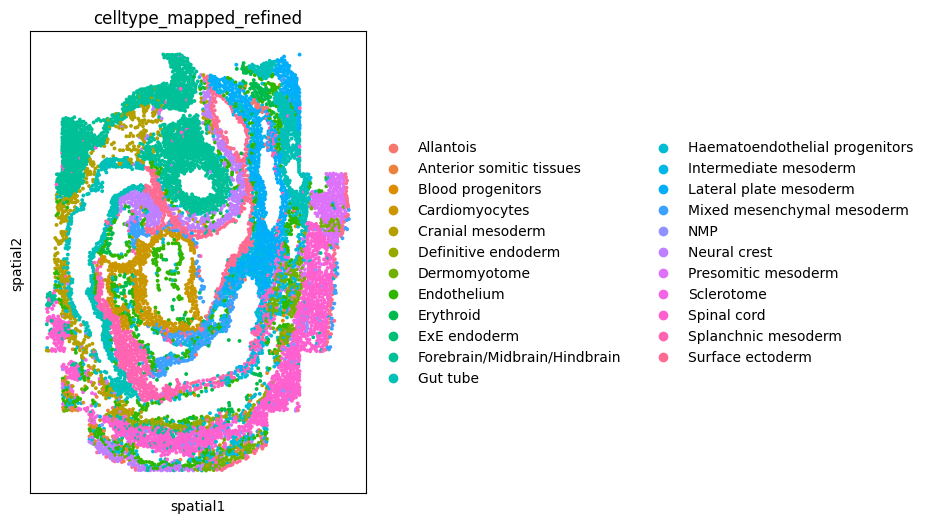

In [8]:
adata.obs = scmetadata

adata.obsm['spatial']=adata.obs[['x_global','y_global']].values

figsize(8,6)
sc.pl.spatial(adata,spot_size=2,basis='spatial',color='celltype_mapped_refined',save='ground_truth.pdf')

# Spaotsc

In [9]:
spaotsc_mappingmtx = pd.read_csv('./result/spaotsc/mousedata_2020_E1z2/mapping.csv',index_col=0)
spaotsc_result,scpred_coord, sc_gtcoord = evaluation(spaotsc_mappingmtx,stcoor,scmetadata,stgtcelltype, celltypelist)

/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [10]:
sc2sc = scipy.spatial.distance.cdist(scpred_coord,scpred_coord)
true_sc2sc = scipy.spatial.distance.cdist(sc_gtcoord,sc_gtcoord)

argmask = np.argsort(sc2sc,axis=1)
true_argmask = np.argsort(true_sc2sc,axis=1)

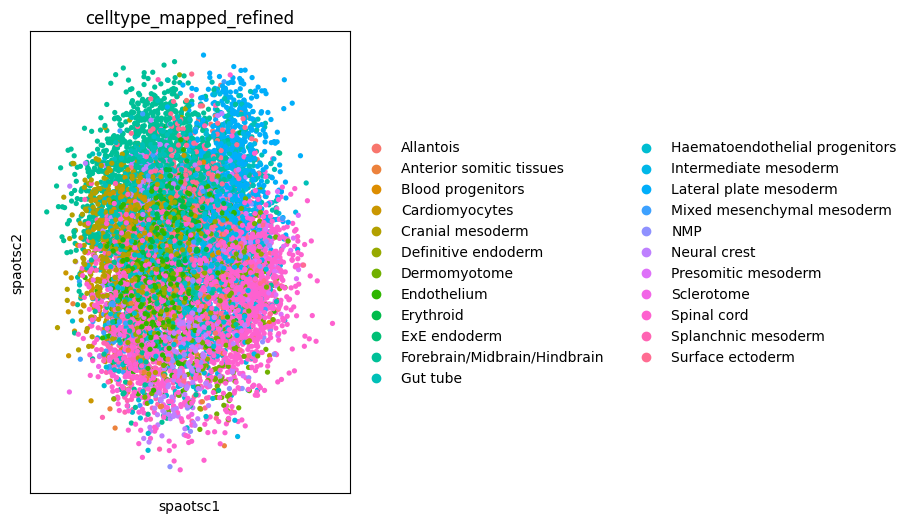

In [11]:
adata.obsm['spaotsc']=scpred_coord
figsize(8,6)
sc.pl.spatial(adata,spot_size=0.5,basis='spaotsc',color='celltype_mapped_refined',save='Spaotsc_all.pdf')

In [12]:
krg = []
for k in range(1,201):
    k_list = []
    for i in range(argmask.shape[0]):
        k_list.append(len(set(argmask[i][:k].tolist()).intersection(set(true_argmask[i][:k].tolist()))))
    krg.append(np.mean(k_list))

krgc['Spaotsc'] = krg

# STEM

In [13]:
da_result=[]
da_mappingmtx = np.load('./result/230215_testdp_pure_mmd-E1z2.npy').T
da_mappingmtx = pd.DataFrame(da_mappingmtx,index = scdata.index, columns=stdata.index)

In [14]:
da_result_tmp1,pred_coord, gt_coord = evaluation(da_mappingmtx,stcoor,scmetadata,stgtcelltype, celltypelist)

/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [15]:
da_result.append(da_result_tmp1[0])
da_result.append(da_result_tmp1[1])

In [16]:
da_mappingmtx = np.load('./result/230215_testdp_pure_sc2st_mmd-E1z2.npy')
da_mappingmtx = pd.DataFrame(da_mappingmtx,index = scdata.index, columns=stdata.index)
da_result_tmp2, spcoor,gtcoor = evaluation(da_mappingmtx,stcoor,scmetadata,stgtcelltype, celltypelist)

/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [17]:
adata.obsm['spatialDA']=spcoor

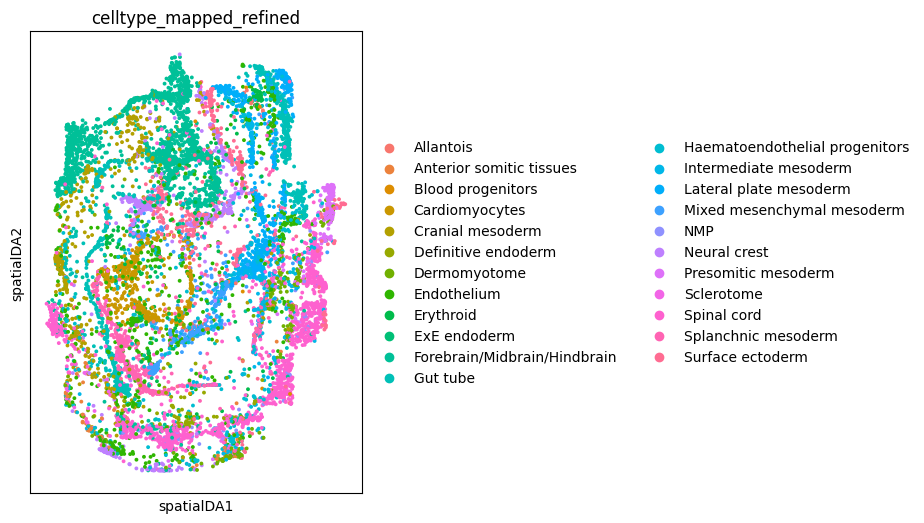

In [18]:
figsize(8,6)
sc.pl.spatial(adata,spot_size=2,basis='spatialDA',color='celltype_mapped_refined',save='STEM_all.pdf')

In [19]:
da_result = da_result + da_result_tmp2[2:]

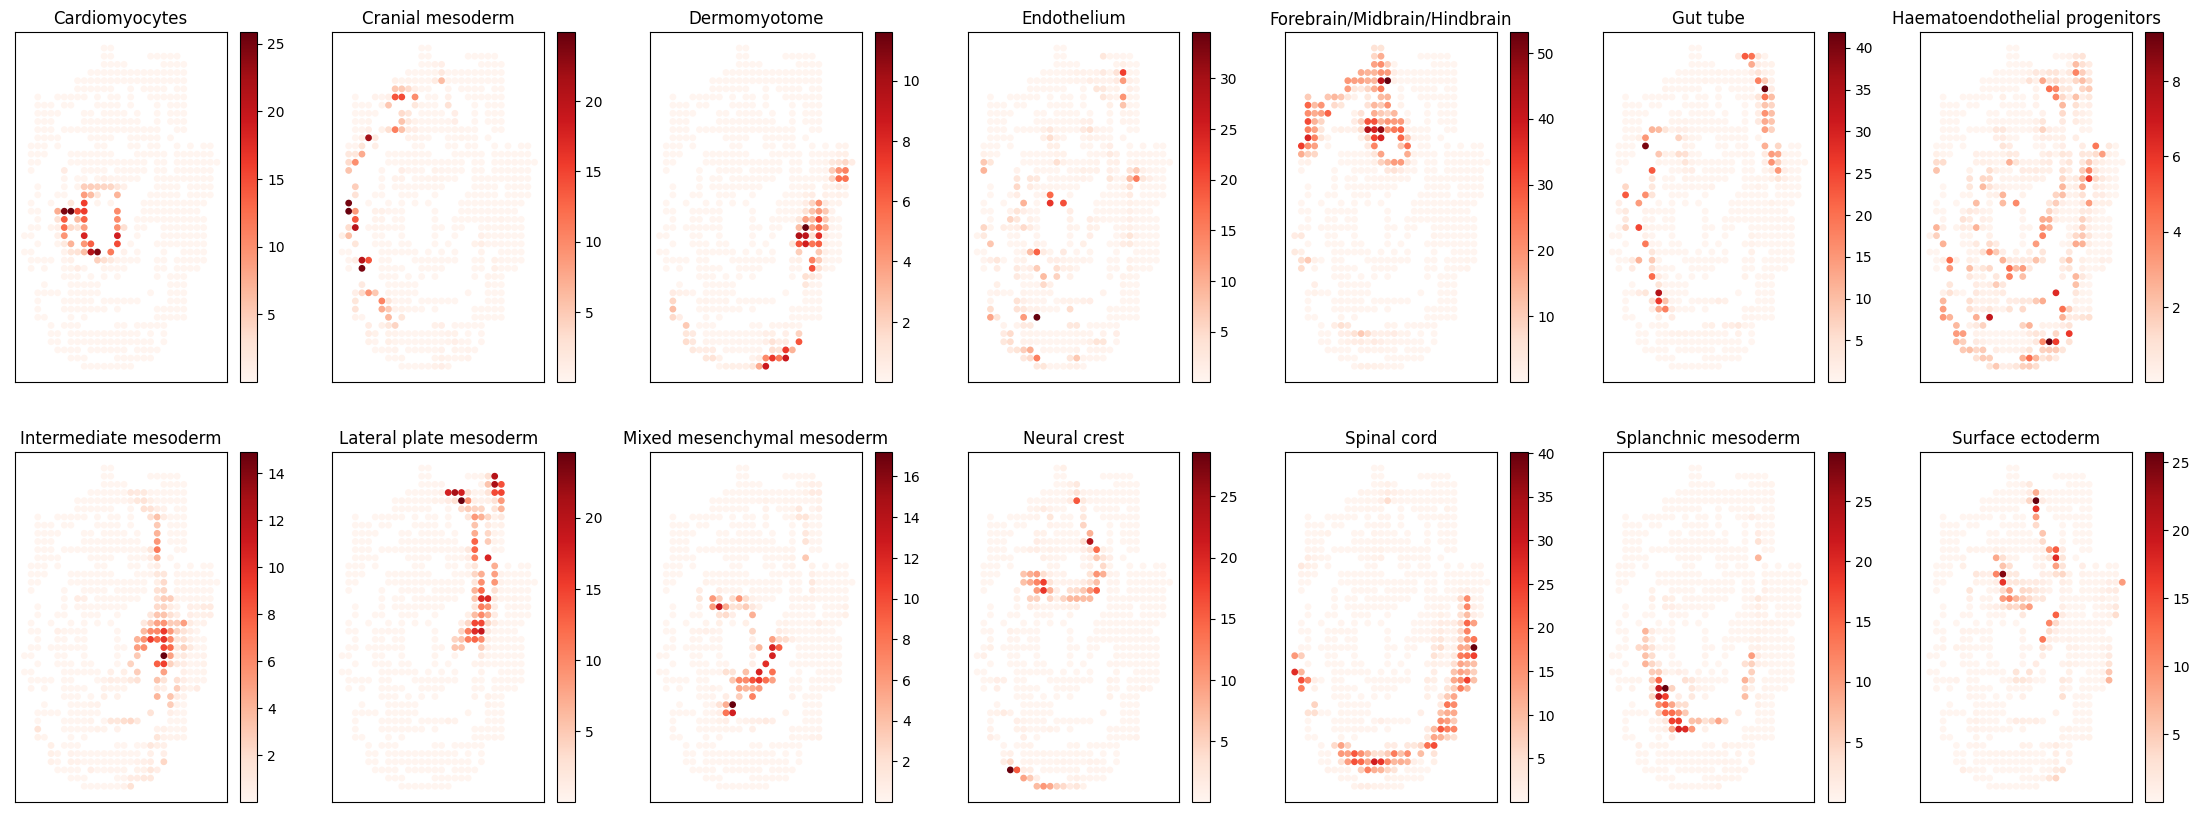

In [20]:
figsize(28,10)
for i in range(len(celltypelist)):
    subplot(2,7,i+1)
    name = celltypelist[i]
    scl =  da_mappingmtx.loc[scmetadata.celltype_mapped_refined==name,].sum(0)
    plt.scatter(stcoor.coord_x,-stcoor.coord_y,c = scl,s=15,cmap='Reds')
    plt.title(name)
    plt.colorbar()
    plt.xticks([])
    plt.yticks([])
plt.savefig('result_E1z2/embro_predours.png',bbox_inches='tight',dpi=330)

In [21]:
scembedding = np.load('./result/230215_scembbedding-E1z2.npy')
stembedding = np.load('./result/230215_stembbedding-E1z2.npy')

In [22]:
sc2sc = np.matmul(scembedding,scembedding.T)
argmask = np.argsort(-sc2sc,axis=1)

In [23]:
from tqdm import tqdm
krg = []
for k in tqdm(range(1,201)):
    k_list = []
    for i in range(argmask.shape[0]):
        k_list.append(len(set(argmask[i][:k].tolist()).intersection(set(true_argmask[i][:k].tolist()))))
    krg.append(np.mean(k_list))
krgc['STEM'] = krg

100%|██████████| 200/200 [00:36<00:00,  5.45it/s]


# Tangram

In [24]:
tg_mappingmtx = np.load('./result/tangram/embroE1z2.npy')
tg_mappingmtx = pd.DataFrame(tg_mappingmtx,index = scdata.index, columns=stdata.index)
tg_result,scpred_coord,_ = evaluation(tg_mappingmtx,stcoor,scmetadata,stgtcelltype,celltypelist)

/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [25]:
sc2sc = scipy.spatial.distance.cdist(scpred_coord,scpred_coord)
argmask = np.argsort(sc2sc,axis=1)

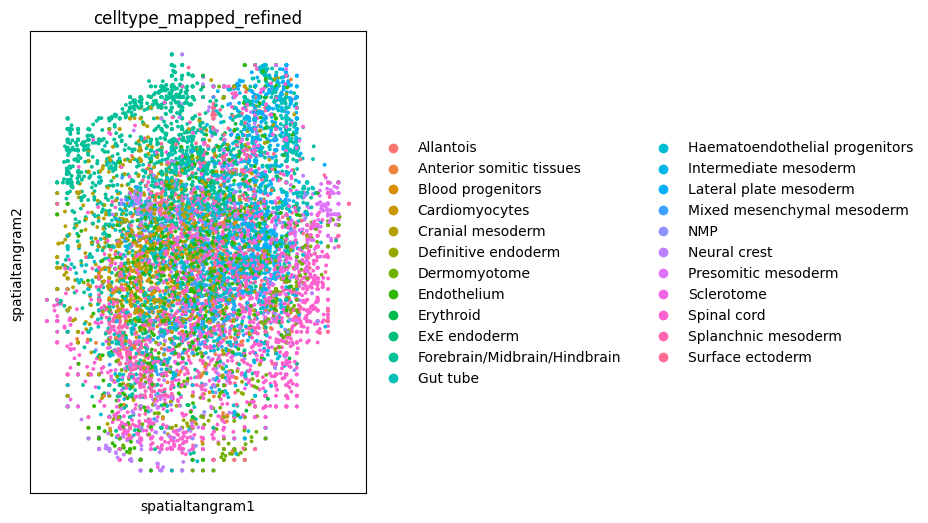

In [26]:
adata.obsm['spatialtangram']=scpred_coord
figsize(8,6)
sc.pl.spatial(adata,spot_size=2,basis='spatialtangram',color='celltype_mapped_refined',save='tangram_all.pdf')

In [27]:
krg = []
for k in tqdm(range(1,201)):
    k_list = []
    for i in range(argmask.shape[0]):
        k_list.append(len(set(argmask[i][:k].tolist()).intersection(set(true_argmask[i][:k].tolist()))))
    krg.append(np.mean(k_list))

krgc['Tangram'] = krg

100%|██████████| 200/200 [00:37<00:00,  5.36it/s]


# CellTrek

In [28]:
celltrekdf = pd.read_csv('./result/celltrek/mousedata_2020_E1z2/xycelltype.csv',index_col=0)

In [29]:
celltrek_celltype = pd.get_dummies(celltrekdf.cell_type)
xy_coord = celltrekdf[['coord_x','coord_y']].values

In [30]:
from tqdm import tqdm
st_anno = np.zeros([stcoor.shape[0],celltrek_celltype.shape[1]])
xbin,ybin = 5.419293802859556, 5.550054857803843
for i in tqdm(range(stcoor.shape[0])):
    xbmin = stcoor.values[i][0]-xbin/100*55/2
    xbmax = stcoor.values[i][0]+xbin/100*55/2
    ybmin = stcoor.values[i][1]-ybin/100*55/2
    ybmax = stcoor.values[i][1]+ybin/100*55/2
    for x in range(xy_coord.shape[0]):
        if xy_coord[x][0]>xbmin and xy_coord[x][0]<=xbmax and xy_coord[x][1]>ybmin and xy_coord[x][1]<=ybmax:
            st_anno[i]+=celltrek_celltype.values[x]

stannodf = pd.DataFrame(st_anno,columns=celltrek_celltype.columns)
stannodf.index = stcoor.index
stannodf = stannodf.div(stannodf.sum(1),0)
stannodf = stannodf.fillna(0)

import scipy
pr_celltrek=[]
for i in range(stgtcelltype.shape[1]):
    pearson = scipy.stats.pearsonr(stgtcelltype.iloc[:,i],stannodf[stgtcelltype.columns[i]])[0]  
    if np.isnan(pearson):
        pearson=0
    pr_celltrek.append(pearson)
pr_celltrek = pd.DataFrame(pr_celltrek,index=stgtcelltype.columns).T

kl_celltrek=[]
for i in range(stgtcelltype.shape[1]):
    scl =  stannodf[stgtcelltype.columns[i]]
    klscore = scipy.special.kl_div(stgtcelltype.iloc[:,i]/stgtcelltype.iloc[:,i].sum(),scl.values/ scl.values.sum()+1e-15).sum()
    kl_celltrek.append(klscore)
kl_celltrek = pd.DataFrame(kl_celltrek,index=stgtcelltype.columns).T

100%|██████████| 581/581 [00:03<00:00, 188.20it/s]
/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
<ipython-input-30-38a43a5e3018>:30: RuntimeWarning: invalid value encountered in true_divide
  klscore = scipy.special.kl_div(stgtcelltype.iloc[:,i]/stgtcelltype.iloc[:,i].sum(),scl.values/ scl.values.sum()+1e-15).sum()


In [31]:
sc_gtcoord = scmetadata[['x_global','y_global']]
celltrekdf = celltrekdf.loc[celltrekdf.index.isin(sc_gtcoord.index),:]
msrate = (celltrekdf.shape[0]/ scmetadata.shape[0])*100
print(f'Celltrek contains {msrate:.2f}% cells')

Celltrek contains 32.47% cells


In [32]:
sc_gtcoord = scmetadata[['x_global','y_global']]
scpred_coord_celltrek = pd.DataFrame(np.zeros_like(sc_gtcoord),index = scmetadata.index,columns=['coord_x','coord_y'])

scpred_coord_celltrek.loc[celltrekdf.index,['coord_x','coord_y']] = celltrekdf.loc[:,['coord_x','coord_y']]

sc2sc = scipy.spatial.distance.cdist(scpred_coord_celltrek,scpred_coord_celltrek)
true_sc2sc = scipy.spatial.distance.cdist(sc_gtcoord,sc_gtcoord)
argmask = np.argsort(sc2sc,axis=1)
true_argmask = np.argsort(true_sc2sc,axis=1)
k_10 = []
k_30 = []
k_50 = []
for i in range(argmask.shape[0]):
    k = 10
    k_10.append(len(set(argmask[i][:k].tolist()).intersection(set(true_argmask[i][:k].tolist()))))
    k = 30
    k_30.append(len(set(argmask[i][:k].tolist()).intersection(set(true_argmask[i][:k].tolist()))))
    k = 50
    k_50.append(len(set(argmask[i][:k].tolist()).intersection(set(true_argmask[i][:k].tolist()))))

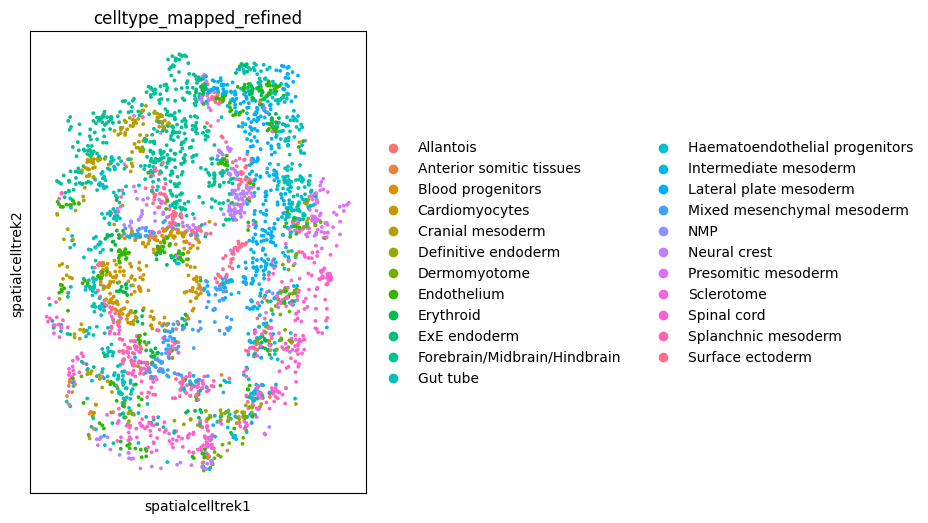

In [33]:
adata.obsm['spatialcelltrek']=scpred_coord_celltrek.values
figsize(8,6)
sc.pl.spatial(adata[adata.obsm['spatialcelltrek'].sum(1)>0],spot_size=2,basis='spatialcelltrek',color='celltype_mapped_refined',save='celltrek_all.pdf')

In [34]:
sc_gtcoord4celltrek = sc_gtcoord.loc[celltrekdf.index,:]
dis_kall = np.sqrt(((sc_gtcoord4celltrek.values - celltrekdf.loc[:,['coord_x','coord_y']].values)**2).sum(1))

celltrek_result = [pr_celltrek,kl_celltrek,np.mean(k_10),np.mean(k_30),np.mean(k_50),dis_kall.mean(),dis_kall.mean(),dis_kall.mean(),dis_kall.mean(),dis_kall]

sc2sc = scipy.spatial.distance.cdist(scpred_coord_celltrek,scpred_coord_celltrek)
argmask = np.argsort(sc2sc,axis=1)

krg = []
for k in tqdm(range(1,201)):
    k_list = []
    for i in range(argmask.shape[0]):
        k_list.append(len(set(argmask[i][:k].tolist()).intersection(set(true_argmask[i][:k].tolist()))))
    krg.append(np.mean(k_list))

krgc['CellTrek'] = krg

100%|██████████| 200/200 [00:30<00:00,  6.52it/s]


# Seurat

In [35]:
seurat_mappingmtx = pd.read_csv('./result/seurat/E1z2_mapping.csv',index_col=0).T
seurat_mappingmtx.columns = stdata.index

In [36]:
seurat_result,pred_coord, gt_coord = evaluation(seurat_mappingmtx,stcoor,scmetadata,stgtcelltype,celltypelist)

/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hms/workspace/Spatialmapping/Release/STEM/evaluate.py:9: RuntimeWarning: divide by zero encountered in true_divide
  argmask = np.argsort(1/mappingmtx.values,axis=1)


In [37]:
scpred_coord = all_coord(seurat_mappingmtx,stcoor)
sc2sc = scipy.spatial.distance.cdist(scpred_coord,scpred_coord)
argmask = np.argsort(sc2sc,axis=1)

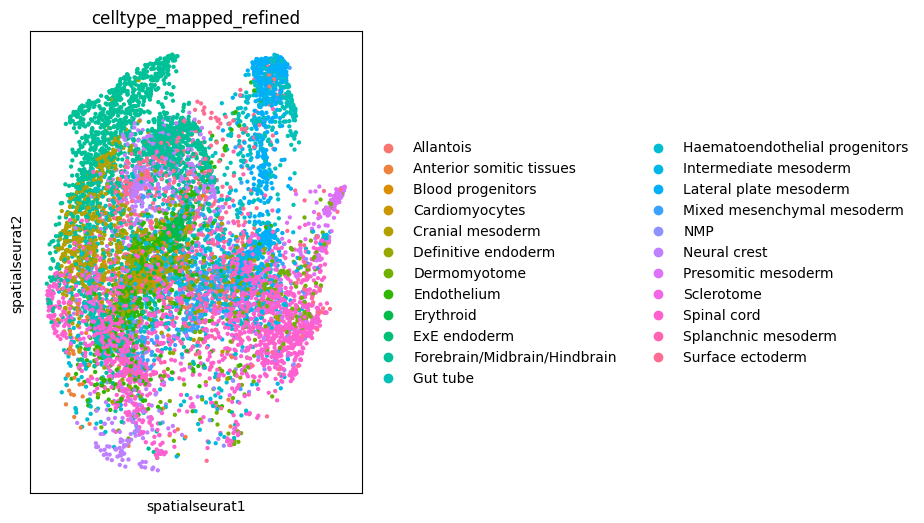

In [38]:
adata.obsm['spatialseurat']=scpred_coord
figsize(8,6)
sc.pl.spatial(adata,spot_size=2,basis='spatialseurat',color='celltype_mapped_refined',save='seurat_all.pdf')

In [39]:
krg = []
for k in tqdm(range(1,201)):
    k_list = []
    for i in range(argmask.shape[0]):
        k_list.append(len(set(argmask[i][:k].tolist()).intersection(set(true_argmask[i][:k].tolist()))))
    krg.append(np.mean(k_list))

krgc['Seurat'] = krg

100%|██████████| 200/200 [00:29<00:00,  6.85it/s]


# scSpace

In [40]:
scspacedf = pd.read_csv('./result/scspace/scspace_pseudo_space_embro_E1z2.csv',index_col=0)

scspacedf.index = scmetadata.index
scspacedf.columns = ['coord_x','coord_y']

scspacedf['cell_type'] = scmetadata.celltype_mapped_refined

scspacedf_celltype = pd.get_dummies(scspacedf.cell_type)

xy_coord = scspacedf[['coord_x','coord_y']].values

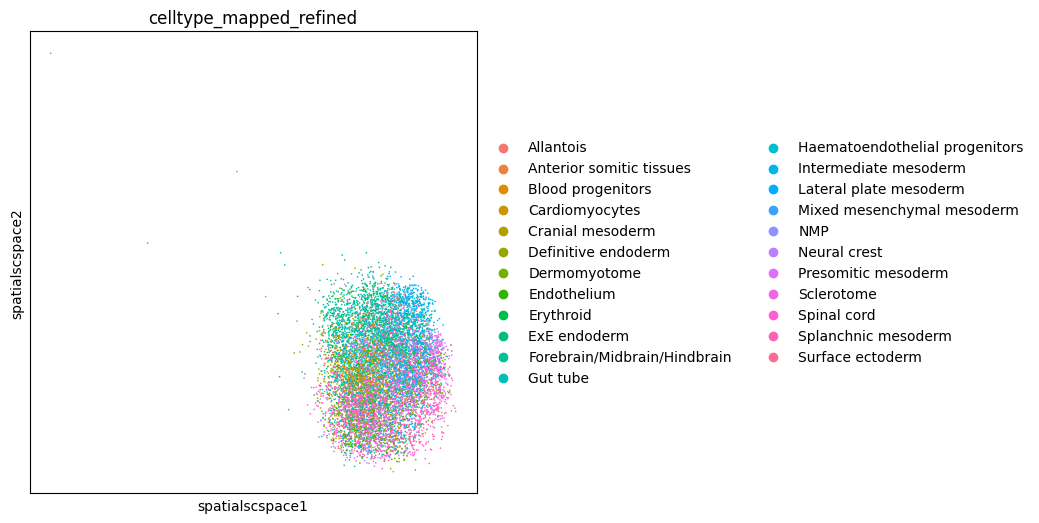

In [41]:
adata.obsm['spatialscspace']=xy_coord
figsize(8,6)
sc.pl.spatial(adata,spot_size=2,basis='spatialscspace',color='celltype_mapped_refined',save='scspace_all.pdf')

In [42]:
from tqdm import tqdm
st_anno = np.zeros([stcoor.shape[0],scspacedf_celltype.shape[1]])
xbin,ybin = 5.419293802859556, 5.550054857803843
for i in tqdm(range(stcoor.shape[0])):
    xbmin = stcoor.values[i][0]-xbin
    xbmax = stcoor.values[i][0]+xbin
    ybmin = stcoor.values[i][1]-ybin
    ybmax = stcoor.values[i][1]+ybin
    for x in range(xy_coord.shape[0]):
        if xy_coord[x][0]>xbmin and xy_coord[x][0]<=xbmax and xy_coord[x][1]>ybmin and xy_coord[x][1]<=ybmax:
            st_anno[i]+=scspacedf_celltype.values[x]

stannodf = pd.DataFrame(st_anno,columns=scspacedf_celltype.columns)
stannodf.index = stcoor.index
stannodf = stannodf.div(stannodf.sum(1),0)
stannodf = stannodf.fillna(0)

import scipy
pr_scspace=[]
for i in range(stgtcelltype.shape[1]):
    pearson = scipy.stats.pearsonr(stgtcelltype.iloc[:,i],stannodf[stgtcelltype.columns[i]])[0]  
    if np.isnan(pearson):
        pearson=0
    pr_scspace.append(pearson)
pr_scspace = pd.DataFrame(pr_scspace,index=stgtcelltype.columns).T

kl_scspace=[]
for i in range(stgtcelltype.shape[1]):
    scl =  stannodf[stgtcelltype.columns[i]]
    klscore = scipy.special.kl_div(stgtcelltype.iloc[:,i]/stgtcelltype.iloc[:,i].sum(),scl.values/ scl.values.sum()+1e-15).sum()
    kl_scspace.append(klscore)
kl_scspace = pd.DataFrame(kl_scspace,index=stgtcelltype.columns).T

100%|██████████| 581/581 [00:02<00:00, 221.10it/s]
/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [43]:
sc_gtcoord = scmetadata[['x_global','y_global']]

In [44]:
sc2sc = scipy.spatial.distance.cdist(xy_coord,xy_coord)
true_sc2sc = scipy.spatial.distance.cdist(sc_gtcoord,sc_gtcoord)
argmask = np.argsort(sc2sc,axis=1)
true_argmask = np.argsort(true_sc2sc,axis=1)
k_10 = []
k_30 = []
k_50 = []
for i in range(argmask.shape[0]):
    k = 10
    k_10.append(len(set(argmask[i][:k].tolist()).intersection(set(true_argmask[i][:k].tolist()))))
    k = 30
    k_30.append(len(set(argmask[i][:k].tolist()).intersection(set(true_argmask[i][:k].tolist()))))
    k = 50
    k_50.append(len(set(argmask[i][:k].tolist()).intersection(set(true_argmask[i][:k].tolist()))))

dis_kall = np.sqrt(((sc_gtcoord.values - xy_coord)**2).sum(1))

In [45]:
scspace_result = [pr_scspace,kl_scspace,np.mean(k_10),np.mean(k_30),np.mean(k_50),dis_kall.mean(),dis_kall.mean(),dis_kall.mean(),dis_kall.mean(),dis_kall]

In [46]:
sc2sc = scipy.spatial.distance.cdist(xy_coord,xy_coord)
argmask = np.argsort(sc2sc,axis=1)

krg = []
for k in tqdm(range(1,201)):
    k_list = []
    for i in range(argmask.shape[0]):
        k_list.append(len(set(argmask[i][:k].tolist()).intersection(set(true_argmask[i][:k].tolist()))))
    krg.append(np.mean(k_list))

krgc['scSpace'] = krg

100%|██████████| 200/200 [00:28<00:00,  7.03it/s]


# Result

In [93]:
import colorbm as cbm
sns.set_palette(sns.color_palette(cbm.pal('npg').as_hex[:6][::-1]))

In [157]:
cbm.pal('npg').as_hex[:6][::-1]

['#8491B4', '#F39B7F', '#3C5488', '#00A087', '#4DBBD5', '#E64B35']

In [47]:
allresult = {'Spaotsc':spaotsc_result,'STEM':da_result,'Tangram':tg_result,'CellTrek':celltrek_result,'Seurat':seurat_result,'scSpace':scspace_result}

In [48]:
import pickle
with open('./result_E1z2/embro_allresult.pkl','wb') as f:
    pickle.dump(allresult,f)

In [49]:
import pickle
with open('./result_E1z2/embro_allresult.pkl','rb') as f:
    allresult = pickle.load(f)

In [50]:
pr_all=[]
for res in allresult.keys():
    tmp = allresult[res][0].loc[:,celltypelist]
    tmp.index = [res]
    pr_all.append(tmp.copy())

pr_all = pd.concat(pr_all,axis=0)
pr_all.fillna(0,inplace=True)

In [51]:
pr_all = pr_all.loc[['CellTrek','scSpace','Seurat','Spaotsc','Tangram','STEM'],:]

In [52]:
pr_boxplot = []
for i in range(pr_all.shape[0]):
    tmp = pd.DataFrame(pr_all.iloc[i,:])
    tmp['name'] = pr_all.index[i]
    tmp.columns = ['values','name']
    pr_boxplot.append(tmp) 
pr_boxplot = pd.concat(pr_boxplot,axis=0)

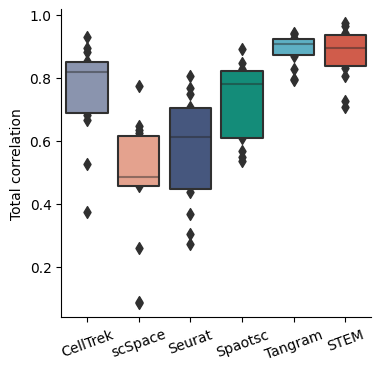

In [94]:
figsize(4,4)
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
sns.boxenplot(data = pr_boxplot,x='name',y='values')
plt.xticks(np.arange(6),pr_all.index,rotation=20);
plt.xlabel('')
plt.ylabel('Total correlation');
plt.savefig('result_E1z2/embro_tissue_all.pdf',bbox_inches='tight',dpi=330)

In [54]:
pr_all.mean(1)

CellTrek    0.755026
scSpace     0.470130
Seurat      0.572932
Spaotsc     0.727175
Tangram     0.889307
STEM        0.875215
dtype: float64

In [55]:
abbr = []
for x in pr_all.columns:
    abbr.append(x[:5]+'.')

In [56]:
pr_all_select = pr_all.loc[:,['Spinal cord','Cardiomyocytes','Lateral plate mesoderm','Endothelium','Surface ectoderm']]

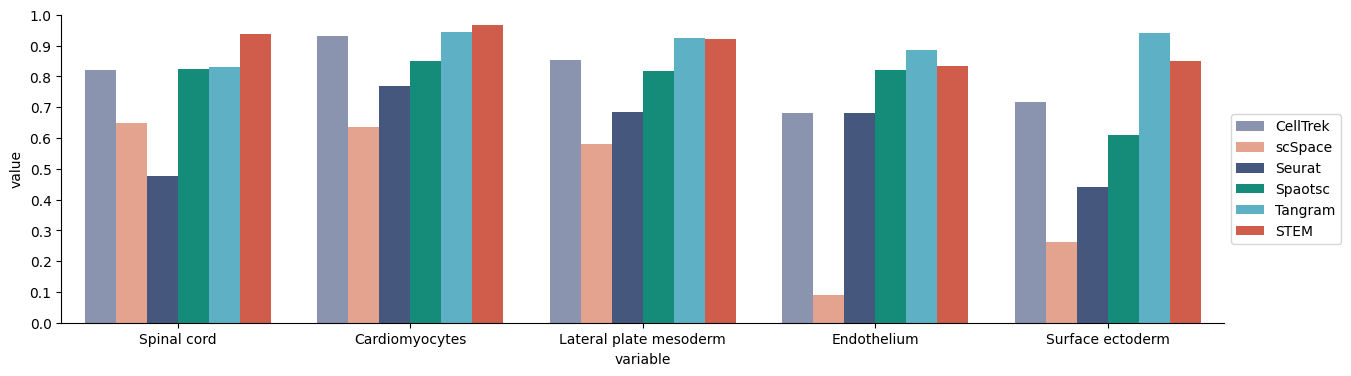

In [125]:
figsize(15,4)
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
dfdraw = pr_all_select.melt(ignore_index=False).reset_index()
sns.barplot(data=dfdraw,x='variable',y='value',hue='index')
plt.ylim(0,1)
plt.yticks(np.arange(0,1.1,0.1))
plt.legend(loc=2,bbox_to_anchor=(1,0.7))
plt.savefig('result_E1z2/embro_tissue_celltype_selected.pdf',bbox_inches='tight',dpi=330)

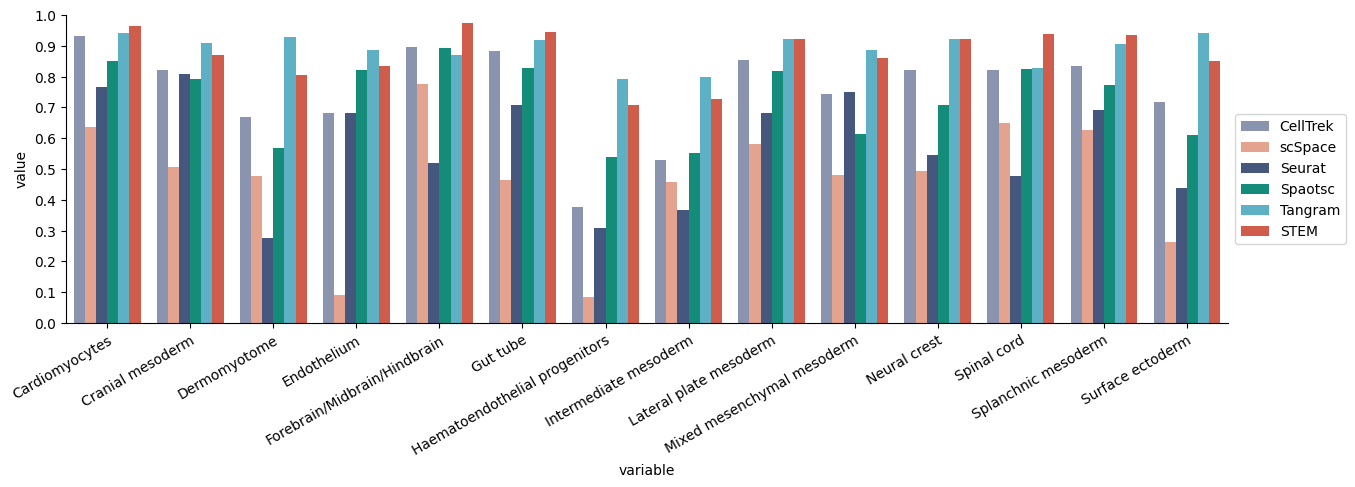

In [127]:
dfdraw = pr_all.melt(ignore_index=False).reset_index()
sns.barplot(data=dfdraw,x='variable',y='value',hue='index')
plt.xticks(index,pr_all,rotation=30,rotation_mode='anchor', ha='right')
plt.ylim(0,1)
plt.yticks(np.arange(0,1.1,0.1))
plt.legend(loc=2,bbox_to_anchor=(1,0.7))
plt.grid(False)
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
plt.savefig('result_E1z2/embro_tissue_celltype.pdf',bbox_inches='tight',dpi=330)


# location error

## Absolute err

In [59]:
dis_allbox=[]
for res in allresult.keys():
    tmp = allresult[res][-1]
    print(res,np.median(tmp),np.mean(tmp))
    
    tmp = pd.DataFrame(tmp).T
    tmp.index = [res]
    dis_allbox.append(tmp.copy())

dis_allbox = pd.concat(dis_allbox,axis=0)
# pr_all.fillna(0,inplace=True)

Spaotsc 61.218453926451005 59.84613640890992
STEM 5.368341425998523 10.632273392190493
Tangram 17.135258570937708 29.27476925266905
CellTrek 12.544646479735023 24.193017464352415
Seurat 22.347194643386473 30.074449076478878
scSpace 27.23868569206916 34.186606082659004


In [60]:
dis_allbox= dis_allbox.loc[['CellTrek','scSpace','Seurat','Spaotsc','Tangram','STEM'],:]

In [61]:
abbr = []
for x in scmetadata.celltype_mapped_refined.values:
    abbr.append(x[:3]+'.')

In [62]:
dis_boxplot = []
for i in range(dis_allbox.shape[0]):
    tmp = pd.DataFrame(dis_allbox.iloc[i,:])
    tmp['name'] = dis_allbox.index[i]
    tmp['celltype'] = abbr
    tmp['fullname_celltype']  = scmetadata.celltype_mapped_refined.tolist()
    tmp.columns = ['values','name','celltype','fullname_celltype']
    dis_boxplot.append(tmp) 
dis_boxplot = pd.concat(dis_boxplot,axis=0)

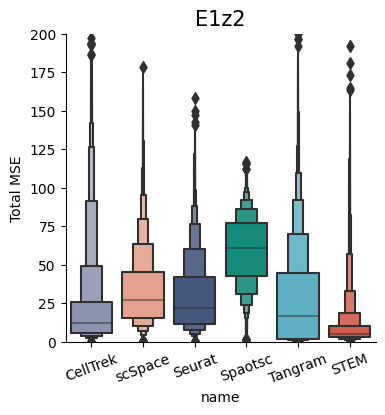

In [98]:
figsize(4,4)
sns.boxenplot(data = dis_boxplot,x='name',y='values')
plt.xticks(rotation=20);
plt.ylim(0,200)
plt.ylabel('Total MSE');
plt.title('E1z2', fontsize=15)
plt.savefig('result_E1z2/embro_tissue_disall.pdf',bbox_inches='tight',dpi=330)

In [64]:
dis_boxplot_selected = dis_boxplot[dis_boxplot.fullname_celltype.isin(['Spinal cord','Cardiomyocytes','Lateral plate mesoderm','Endothelium','Surface ectoderm'])]

In [156]:
dis_allbox

,0,1,2,3,4,5,6,7,8,9,...,10140,10141,10142,10143,10144,10145,10146,10147,10148,10149
CellTrek,8.284647,91.509679,90.687660,153.411148,143.653447,9.541699,9.426466,4.545111,8.332488,9.654037,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
scSpace,82.054541,25.097459,21.516109,65.122545,22.801091,31.577827,7.537837,12.251037,10.257921,73.402629,...,13.683597,4.627806,36.570943,28.514309,11.058189,9.838828,21.592304,6.162448,2.043213,17.284256
Seurat,77.488678,89.201937,22.238775,83.718730,5.110978,78.646516,10.282469,3.314600,18.818427,28.171060,...,6.586287,12.514981,11.945291,114.104945,9.997793,19.207019,29.096631,25.710971,29.449591,12.309456
Spaotsc,87.091414,87.977286,97.256321,85.659313,77.121076,82.712610,74.719668,68.223932,78.417603,95.586352,...,93.238700,102.364640,78.416631,116.101023,93.072675,78.382032,92.190487,103.489153,88.183809,82.149995
Tangram,0.531692,1.586233,1.392872,58.003155,1.348086,1.295449,11.813986,1.579921,23.432970,2.880513,...,20.984686,12.593144,6.518990,190.017831,31.881192,1.207283,30.573280,1.472783,22.455831,1.015313
STEM,2.018424,3.528314,0.768732,4.335239,2.482932,1.667375,2.425827,6.418137,3.971757,2.915998,...,7.198722,1.695104,8.719851,181.288891,5.853615,6.552510,8.709431,0.469605,11.463778,6.686251


In [155]:
dis_boxplot[dis_boxplot.fullname_celltype.isin(['Cardiomyocytes'])]

,values,name,celltype,fullname_celltype
4022,NaN,CellTrek,Car.,Cardiomyocytes
4051,NaN,CellTrek,Car.,Cardiomyocytes
4083,NaN,CellTrek,Car.,Cardiomyocytes
4086,NaN,CellTrek,Car.,Cardiomyocytes
4092,NaN,CellTrek,Car.,Cardiomyocytes
...,...,...,...,...
7336,4.251899,STEM,Car.,Cardiomyocytes
7344,15.684254,STEM,Car.,Cardiomyocytes
7355,4.222828,STEM,Car.,Cardiomyocytes
7358,2.311935,STEM,Car.,Cardiomyocytes


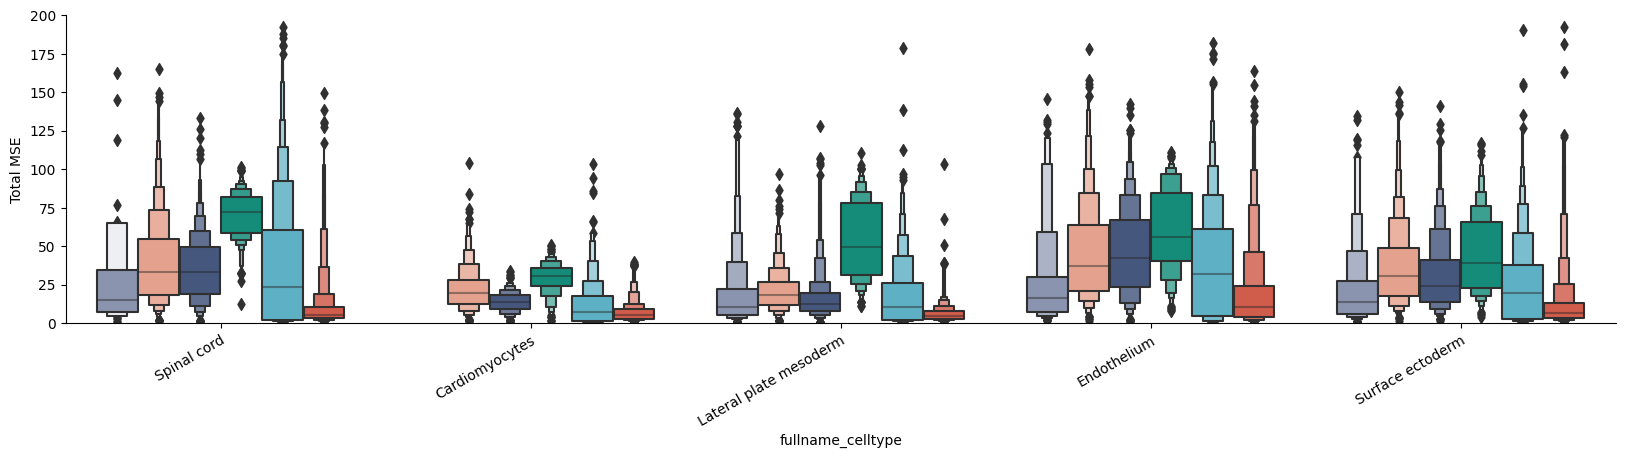

In [153]:
figsize(20,4)
ax = sns.boxenplot(data = dis_boxplot_selected,x='fullname_celltype',y='values',hue='name',order=['Spinal cord','Cardiomyocytes','Lateral plate mesoderm','Endothelium','Surface ectoderm'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=30,rotation_mode='anchor', ha='right')
plt.ylim(0,200)
ax.legend_.remove()
plt.ylabel('Total MSE');
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
plt.savefig('result_E1z2/embro_tissue_disct_selcted.pdf',bbox_inches='tight',dpi=330)

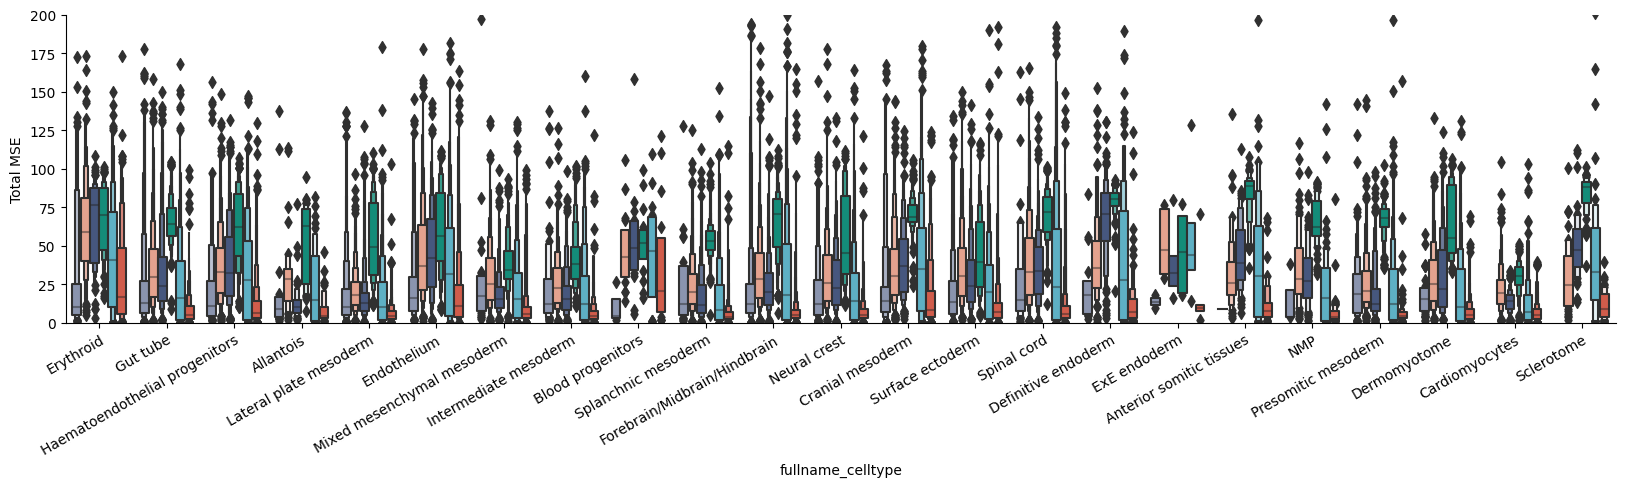

In [102]:
figsize(20,4)
ax = sns.boxenplot(data = dis_boxplot,x='fullname_celltype',y='values',hue='name')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30,rotation_mode='anchor', ha='right')
plt.ylim(0,200)
ax.legend_.remove()
plt.ylabel('Total MSE');
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
plt.savefig('result_E1z2/embro_tissue_disct.pdf',bbox_inches='tight',dpi=330)

In [67]:
MSEdf = {}
for res in allresult.keys():
    tmp = allresult[res][5:9]
    MSEdf[res] = tmp

In [68]:
pd.DataFrame(MSEdf).T

,0,1,2,3
Spaotsc,21.341388,29.378523,35.150522,59.846136
STEM,10.561886,10.591749,10.608179,10.632273
Tangram,29.273577,29.269740,29.270262,29.274769
CellTrek,24.193017,24.193017,24.193017,24.193017
Seurat,28.415783,30.065950,30.074449,30.074449
scSpace,34.186606,34.186606,34.186606,34.186606


## @K

In [69]:
figsize(5,4)
kn = []
for res in allresult.keys():
    kn.append(pd.DataFrame([allresult[res][2:5]],index=[res],columns=['@K10','@K30','@K50']))
kn = pd.concat(kn,axis=0)

In [70]:
krgcdf = pd.DataFrame(krgc)
krgcdf = krgcdf.loc[:,pr_all.index]

In [129]:
krgcdf.melt()

,variable,value
0,CellTrek,0.324828
1,CellTrek,0.326601
2,CellTrek,0.332808
3,CellTrek,0.344039
4,CellTrek,0.356256
...,...,...
1195,STEM,95.538227
1196,STEM,96.117537
1197,STEM,96.685320
1198,STEM,97.254187


In [130]:
dfdraw = krgcdf.melt(ignore_index=False).reset_index()

In [158]:
colorb

['#8491B4', '#F39B7F', '#3C5488', '#00A087', '#4DBBD5', '#E64B35']

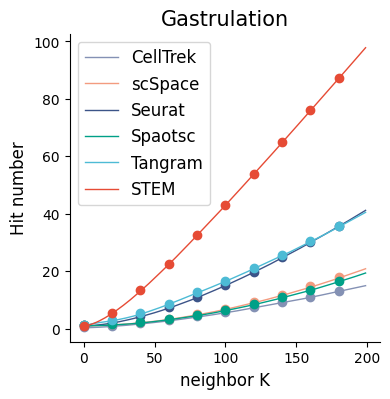

In [147]:
# color = ['blue','green','brown','purple','c','#DC493A']
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
figsize(4,4)
# prop_cycle = plt.rcParams['axes.prop_cycle']
# color = prop_cycle.by_key()['color']
color=cbm.pal('npg').as_hex[:6][::-1]
for i in range(krgcdf.shape[1]):
    plt.plot(np.arange(200),krgcdf.iloc[:,i],label=krgcdf.columns[i],c=color[i],linestyle ='-',lw=1)
    for j in range(10):
        plt.plot(j*20,krgcdf.iloc[j*20,i]+0.25,c=color[i],marker ='o')
# sns.scatterplot(data = dfdraw[dfdraw['index']%20==0],x='index',y='value',hue='variable',legend=False,s=70)
# sns.lineplot(data = dfdraw,x='index',y='value',hue='variable',lw=2)

plt.legend( fontsize=12)
plt.ylabel('Hit number', fontsize=12)
plt.xlabel('neighbor K', fontsize=12)
plt.title('Gastrulation', fontsize=15)
plt.savefig('result_E1z2/embro_k.pdf',bbox_inches='tight',dpi=330)

In [72]:
krgcdf.to_csv('./result_E1z2/embro_krgc.csv')

In [75]:
np.std([0.87,0.86,0.82])

0.021602468994692887

In [76]:
np.mean([0.87,0.86,0.82])

0.85

In [78]:
np.mean([0.88,0.89,0.85])

0.8733333333333334

In [79]:
np.std([0.88,0.89,0.85])

0.016996731711975962